In [40]:
import csv
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def merge_csi_label(csifile, labelfile, win_len=366, thrshd=0.6, step=2):
    activity = []
    with open(labelfile, 'r') as labelf:
        reader = csv.reader(labelf)
        for line in reader:
            label = line[0]
            activity.append(0 if label == 'NoActivity' else 1)
    activity = np.array(activity)
    csi = []
    with open(csifile, 'r') as csif:
        reader = csv.reader(csif)
        for line in reader:
            line_array = np.array([float(v) for v in line[0:52]])
            csi.append(line_array[np.newaxis, ...])
    csi = np.concatenate(csi, axis=0)
    assert csi.shape[0] == activity.shape[0]

    index = 0
    feature = []
    while index + win_len <= csi.shape[0]:
        cur_activity = activity[index:index+win_len]
        if np.sum(cur_activity) < thrshd * win_len:
            index += step
            continue
        cur_feature = csi[index:index+win_len, :][np.newaxis, ...]
        feature.append(cur_feature)
        index += step
    return np.concatenate(feature, axis=0)

def extract_csi_by_label(raw_folder, label, labels, win_len=366, thrshd=0.6, step=2):
    data_path_pattern = os.path.join(raw_folder, label + '*_data.csv')
    input_csv_files = sorted(glob.glob(data_path_pattern))
    annot_csv_files = [os.path.join(raw_folder, os.path.basename(f).replace('_data', '_label')) for f in input_csv_files]
    
    feature = []
    for csi_file, label_file in zip(input_csv_files, annot_csv_files):
        if os.path.exists(label_file):
            feature.append(merge_csi_label(csi_file, label_file, win_len, thrshd, step))
    feat_arr = np.concatenate(feature, axis=0)
    feat_label = np.zeros((feat_arr.shape[0], len(labels)))
    feat_label[:, labels.index(label)] = 1
    return feat_arr, feat_label

def train_valid_split(data, train_portion=0.80, seed=89):
    np.random.seed(seed)
    x_train, y_train, x_valid, y_valid = [], [], [], []
    for i, (x, y) in enumerate(data):
        indices = np.random.permutation(len(x))
        split = int(train_portion * len(x))
        x_train.append(x[indices[:split]])
        y_train.append(y[indices[:split]])
        x_valid.append(x[indices[split:]])
        y_valid.append(y[indices[split:]])
    return (
        np.concatenate(x_train), np.concatenate(y_train),
        np.concatenate(x_valid), np.concatenate(y_valid)
    )


In [41]:
class AttentionLayer(nn.Module):
    def __init__(self, num_state, input_dim):
        super(AttentionLayer, self).__init__()
        self.kernel = nn.Linear(input_dim, num_state)
        self.bias = nn.Parameter(torch.zeros(num_state))
        self.prob_kernel = nn.Linear(num_state, 1, bias=False)
    
    def forward(self, x):
        attention_state = torch.tanh(self.kernel(x) + self.bias)
        logits = self.prob_kernel(attention_state).squeeze(-1)
        probs = torch.softmax(logits, dim=1)
        weighted_feature = (x * probs.unsqueeze(-1)).sum(dim=1)
        return weighted_feature

In [42]:
import torch
import torch.nn as nn

class CSIModel(nn.Module):
    def __init__(self, input_dim=52, lstm_units=150, atten_units=300, output_dim=4):
        super(CSIModel, self).__init__()
        self.bilstm1 = nn.LSTM(input_dim, lstm_units, batch_first=True, bidirectional=True)
        self.bilstm2 = nn.LSTM(lstm_units * 2, lstm_units, batch_first=True, bidirectional=True)
        self.attention = AttentionLayer(atten_units, lstm_units * 2)
        self.fc = nn.Linear(lstm_units * 2, output_dim)
    
    def forward(self, x):
        lstm_out1, _ = self.bilstm1(x)
        lstm_out2, _ = self.bilstm2(lstm_out1)
        att_out = self.attention(lstm_out2)
        return self.fc(att_out)


In [43]:
# try fyp
raw_data_folder = '../FYP_Data/Dataset/'
labels = ["jump1", "nopeople1"]


# raw_data_folder = '../Data/Dataset/'
# labels = ["fall", "run", "stand", "walk"]

data = [extract_csi_by_label(raw_data_folder, label, labels) for label in labels]

x_train, y_train, x_valid, y_valid = train_valid_split(data)

train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
valid_dataset = TensorDataset(torch.tensor(x_valid, dtype=torch.float32), torch.tensor(y_valid, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"GPU in use: {device}")

model = CSIModel(output_dim=len(labels)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

history = {"epoch": [], "train_accuracy": [], "train_loss": [], "test_accuracy": [], "test_loss": []}

for epoch in range(40):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)

        loss = criterion(y_pred, torch.argmax(y_batch, axis=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (torch.argmax(y_pred, axis=1) == torch.argmax(y_batch, axis=1)).sum().item()
        total += y_batch.size(0)

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total

    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x_batch, y_batch in valid_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)

            loss = criterion(y_pred, torch.argmax(y_batch, axis=1))
            total_loss += loss.item()
            correct += (torch.argmax(y_pred, axis=1) == torch.argmax(y_batch, axis=1)).sum().item()
            total += y_batch.size(0)

    test_loss = total_loss / len(valid_loader)
    test_accuracy = correct / total

    history["epoch"].append(epoch + 1)
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    history["test_loss"].append(test_loss)
    history["test_accuracy"].append(test_accuracy)

    print(f"Epoch {epoch+1}, Train Acc: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, "
          f"Test Acc: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

MODEL_NUM = 1

torch.save(model.state_dict(), f"./model_{MODEL_NUM}.pth")
print("Model saved successfully.")

history_path = f"./history_{MODEL_NUM}.json"
with open(history_path, "w") as f:
    json.dump(history, f)
print(f"Training history saved")


GPU in use: cuda
Epoch 1, Train Acc: 0.0000, Train Loss: 0.7074, Test Acc: 0.1667, Test Loss: 0.6972
Epoch 2, Train Acc: 0.0000, Train Loss: 0.7014, Test Acc: 0.1667, Test Loss: 0.6934
Epoch 3, Train Acc: 0.0000, Train Loss: 0.6956, Test Acc: 1.0000, Test Loss: 0.6895
Epoch 4, Train Acc: 1.0000, Train Loss: 0.6897, Test Acc: 0.8333, Test Loss: 0.6857
Epoch 5, Train Acc: 1.0000, Train Loss: 0.6839, Test Acc: 0.8333, Test Loss: 0.6819
Epoch 6, Train Acc: 1.0000, Train Loss: 0.6781, Test Acc: 0.8333, Test Loss: 0.6781
Epoch 7, Train Acc: 1.0000, Train Loss: 0.6724, Test Acc: 0.8333, Test Loss: 0.6743
Epoch 8, Train Acc: 1.0000, Train Loss: 0.6667, Test Acc: 0.8333, Test Loss: 0.6707
Epoch 9, Train Acc: 1.0000, Train Loss: 0.6610, Test Acc: 0.8333, Test Loss: 0.6671
Epoch 10, Train Acc: 1.0000, Train Loss: 0.6554, Test Acc: 0.8333, Test Loss: 0.6634
Epoch 11, Train Acc: 1.0000, Train Loss: 0.6498, Test Acc: 0.8333, Test Loss: 0.6599
Epoch 12, Train Acc: 1.0000, Train Loss: 0.6442, Test Acc

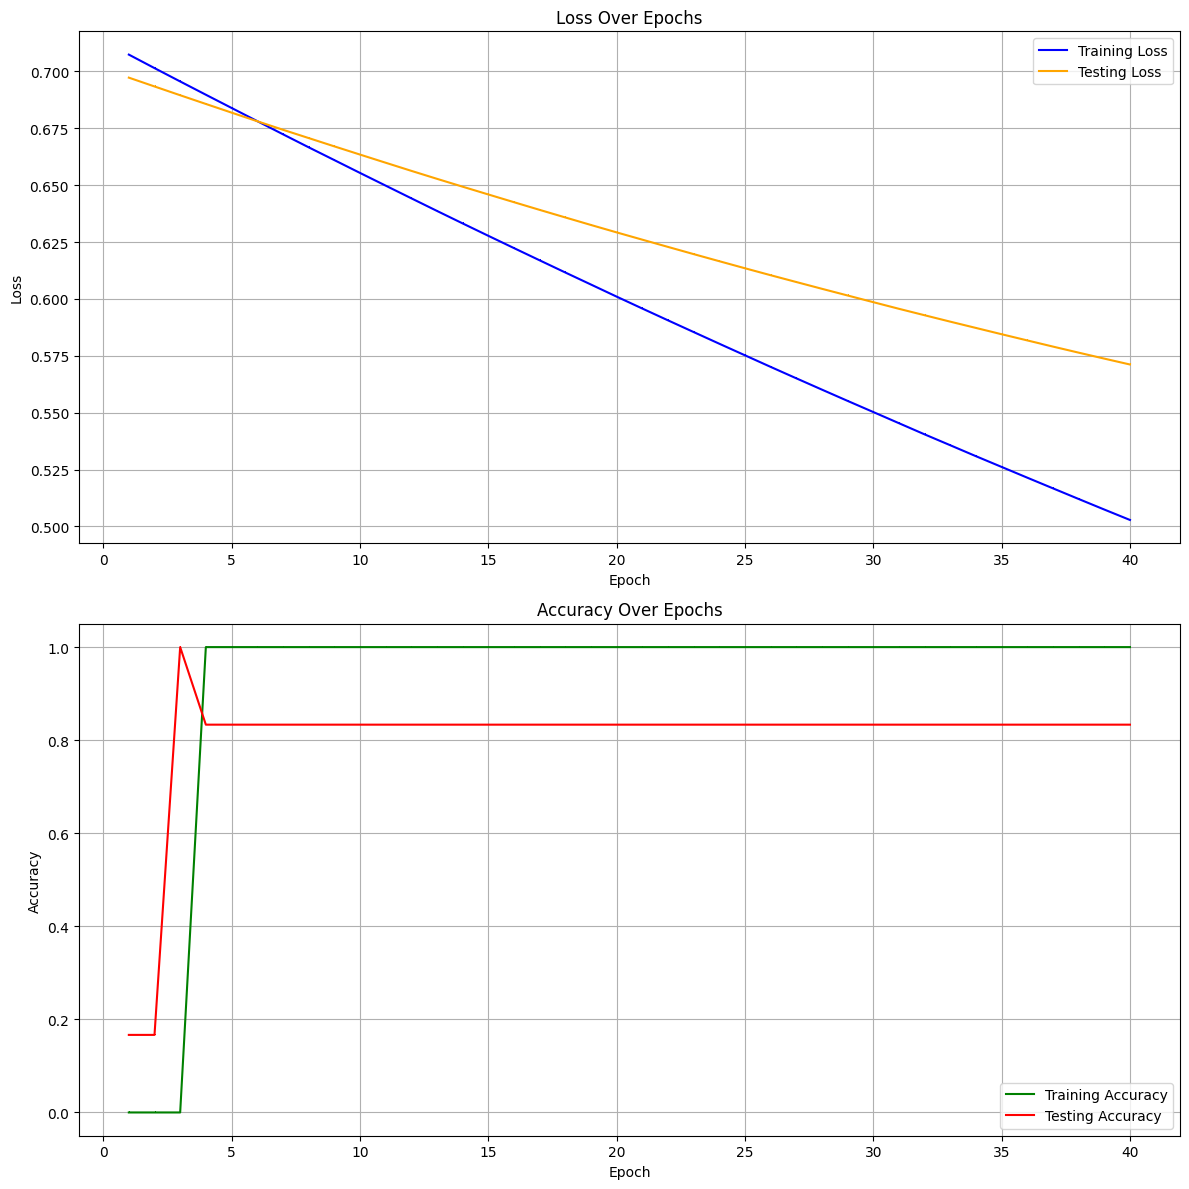

Curve Plot saved


In [45]:
with open(history_path, "r") as f:
    history = json.load(f)

epochs = history["epoch"]
train_loss = history["train_loss"]
train_accuracy = history["train_accuracy"]
test_loss = history["test_loss"]
test_accuracy = history["test_accuracy"]

# Plotting
plt.figure(figsize=(12, 12))

# Loss curve
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss, label="Training Loss", color="blue", marker=",")
plt.plot(epochs, test_loss, label="Testing Loss", color="orange", marker=",")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Accuracy curve
plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracy, label="Training Accuracy", color="green", marker=",")
plt.plot(epochs, test_accuracy, label="Testing Accuracy", color="red", marker=",")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plot_path = f"./plot_{MODEL_NUM}.png"
plt.savefig(plot_path, bbox_inches="tight")
plt.show()
print(f"Curve Plot saved")


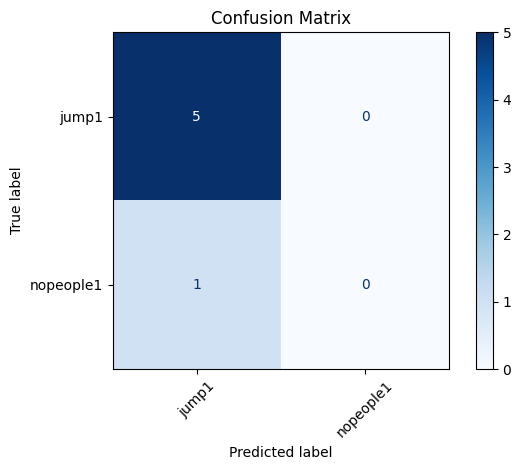

Confusion matrix saved


In [46]:
def plot_confusion_matrix(model, loader, labels, device, save_path):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            predictions = model(x_batch)
            y_true.extend(torch.argmax(y_batch, axis=1).cpu().numpy())
            y_pred.extend(torch.argmax(predictions, axis=1).cpu().numpy())

    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))


    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()

confusion_matrix_path = f"./confusion_matrix_{MODEL_NUM}.png"
plot_confusion_matrix(model, valid_loader, labels, device, confusion_matrix_path)
print(f"Confusion matrix saved")


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "model_1.pth"

model = CSIModel(output_dim=len(labels))
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

print("Model loaded successfully.")


Model loaded successfully.


C:\Users\Jessica\AppData\Local\Temp\ipykernel_15920\859188426.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

In [48]:
def metrics(model, loader, labels, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in loader:
            if len(batch) == 2:
                x_batch, y_batch = batch
            elif len(batch) > 2:
                x_batch, y_batch = batch[:2] 
            else:
                raise ValueError("Unexpected DataLoader output structure.")
            
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            predictions = model(x_batch)
            y_true.extend(torch.argmax(y_batch, axis=1).cpu().numpy())
            y_pred.extend(torch.argmax(predictions, axis=1).cpu().numpy())

    report = classification_report(y_true, y_pred, target_names=labels)
    print(report)

metrics(model, valid_loader, labels, device)


              precision    recall  f1-score   support

       jump1       0.83      1.00      0.91         5
   nopeople1       0.00      0.00      0.00         1

    accuracy                           0.83         6
   macro avg       0.42      0.50      0.45         6
weighted avg       0.69      0.83      0.76         6



c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
